In [1]:
## Author: Juan Maroñas (jmaronasm@gmail.com). Machine Learning Group, Universidad Autónoma de Madrid
## Deep into Prophet through Tutorials

## Introduction to prophet: point estimate vs MCMC and what outputs prophets give when fitting a model.

In [2]:
## Python
import os

## Standard
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

usetex = mpl.checkdep_usetex(True)

mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': usetex,
    'pgf.rcfonts': False,
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
})

mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amssymb,amsfonts,amsthm}'
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 25
mpl.rcParams['axes.titlesize'] = 25


## Prophet
from prophet import Prophet

In [3]:
## Read data
data_dir = os.path.join('../data/','example_retail_sales.csv')
df       = pd.read_csv(data_dir)

# cast to datetime type
df['ds_plot'] = df['ds']
df['ds']      = pd.to_datetime(df['ds'])



Text(0.5, 1.0, 'Whole temporal serie')

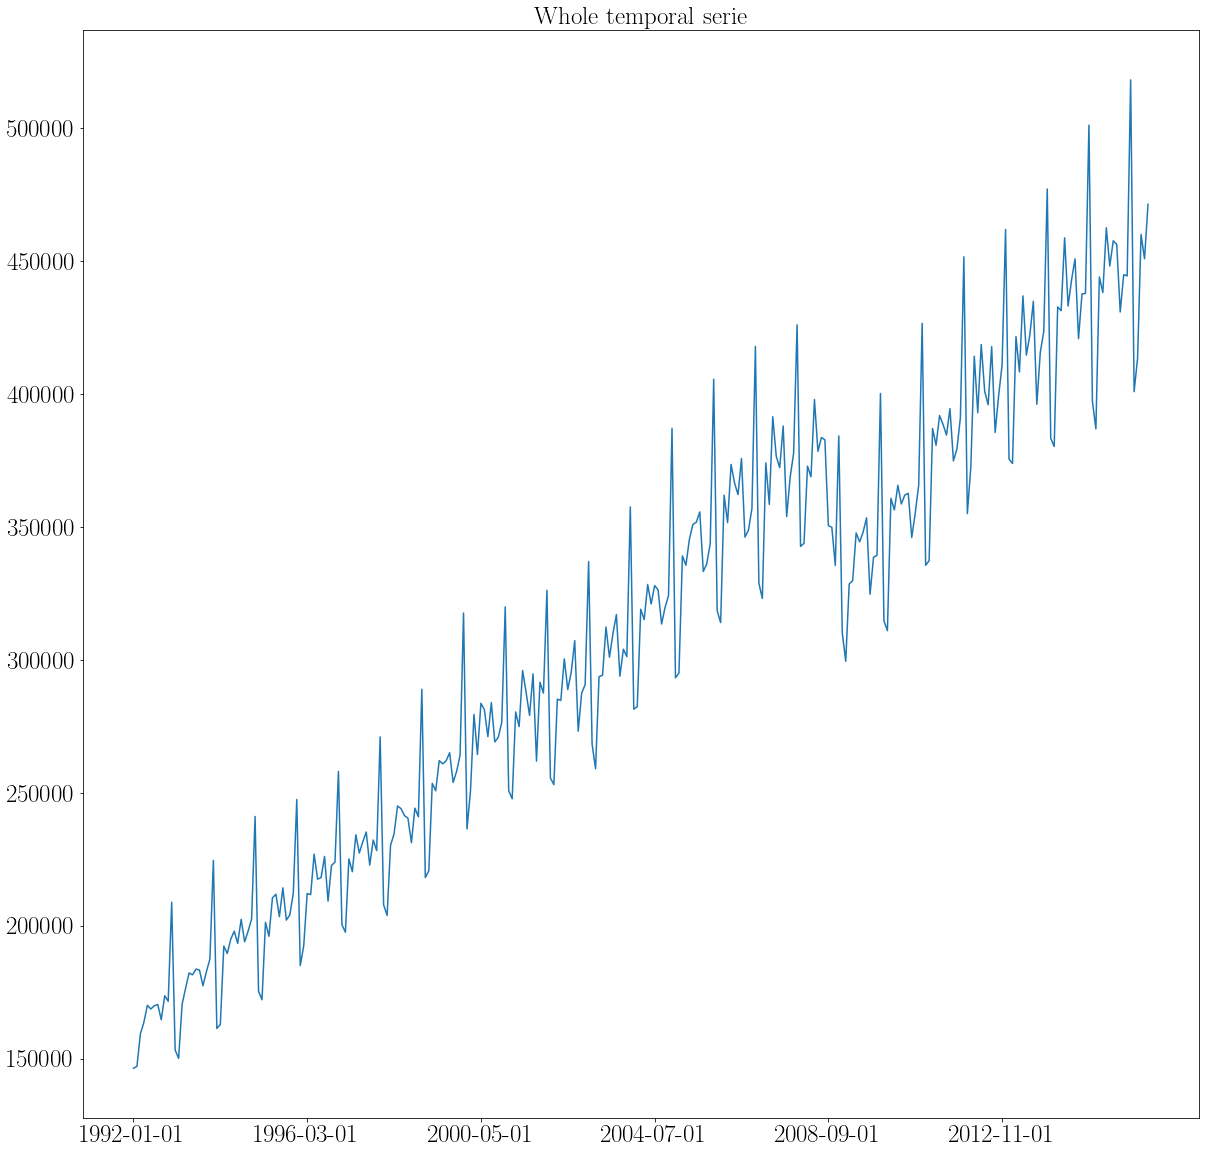

In [4]:
## Visualize whole series
fig, ax = plt.subplots(1,1,figsize=(20,20))

x = np.arange(0,len(df['y']))

ax.plot(x,df['y'])
ax.set_xticks(x[0::50], labels = df['ds_plot'][0::50])
ax.set_title('Whole temporal serie')




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


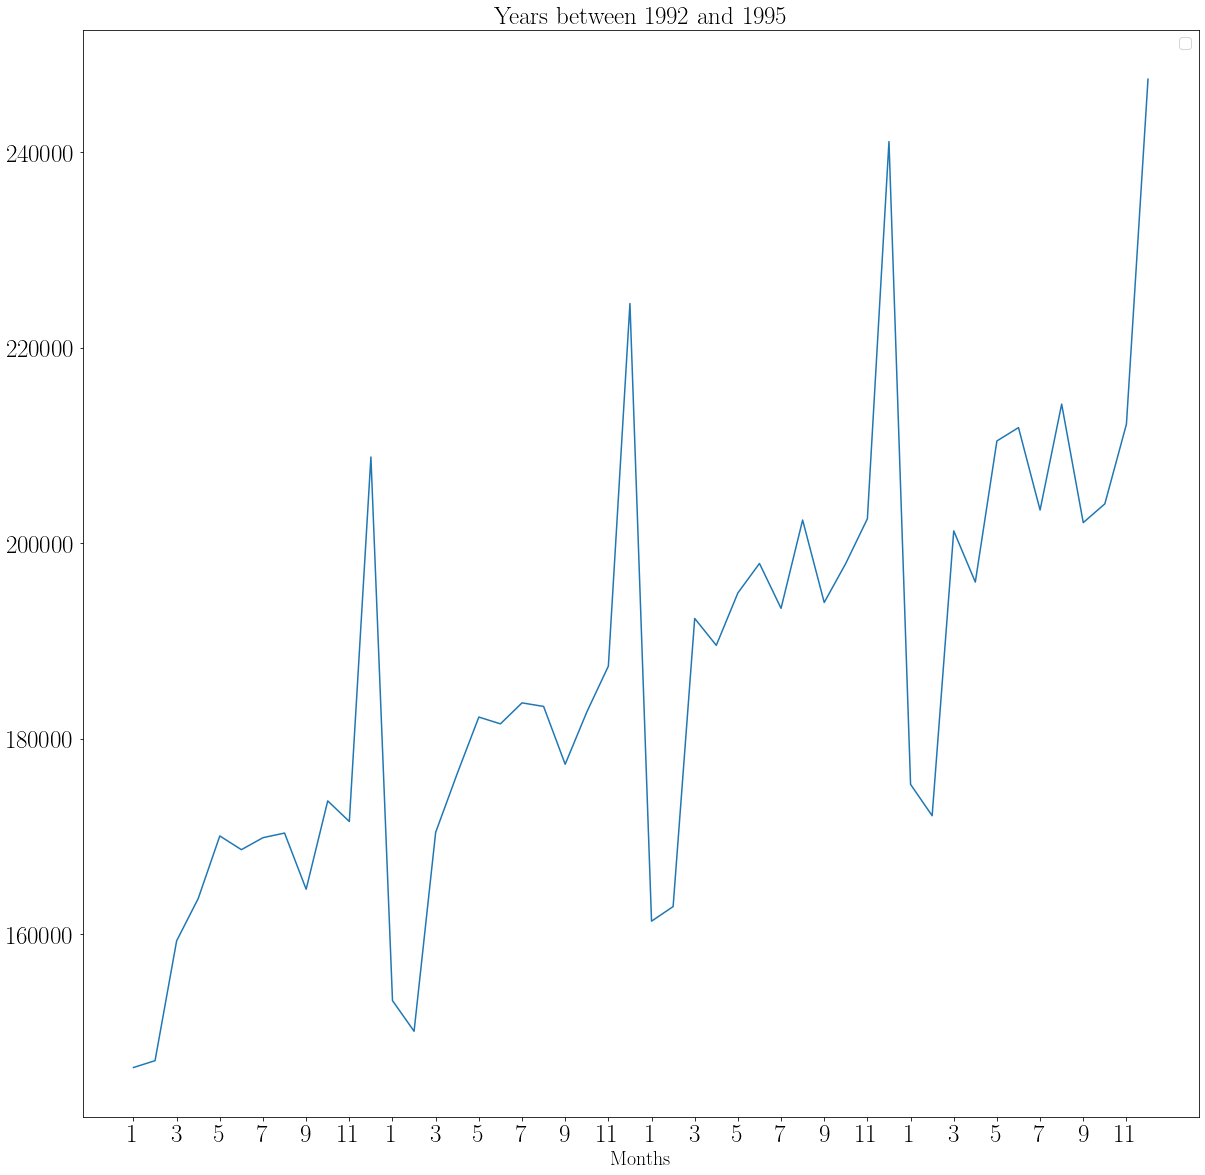

In [5]:
## Visualize just a year
target_years = [1992, 1995]
df_one_year  = df[ (df['ds'].dt.year >= target_years[0]) & (df['ds'].dt.year <= target_years[-1]) ]
                   
fig, ax = plt.subplots(1,1,figsize=(20,20))

x = np.arange(0,len(df_one_year['y']))

ax.plot(x,df_one_year['y'])
ax.set_xticks(x[0::2], labels =  df_one_year['ds'].dt.month[0::2])
ax.set_title('Years between {} and {}'.format(target_years[0],target_years[-1]))
ax.set_xlabel('Months')
ax.legend()


In [6]:
## ========================================================================================== ##
## ================================== Fit using Point Estimate  ============================= ##

## Create prophet model
model = Prophet(interval_width=0.95,  uncertainty_samples = 2000) # Use 50000 or 2000


In [7]:
## Train the model using point estimates. The output in stdout is that given by Stan.
model.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.41173


/home/jmaronasm/.conda/envs/PROPHET_TUTORIAL/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       992.203    0.00196604       355.976       0.233           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     186        1007.8   8.47282e-05       129.678   1.032e-06       0.001      274  LS failed, Hessian reset 
     199       1008.35    0.00065514       105.358           1           1      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1012.05     0.0054502       182.274      0.9218      0.9218      403   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1019.85   0.000413942       186.521      0.9064      0.9064      525   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        1020.8   0.000559727       86.0401           1           1      6

In [8]:
## Make a prediction. In this case we predict in the same time slot we have train on
forecast = model.predict(df)

'''
    Prophet gives the following outputs regarding the forecast when making predictions
    
    yhat: the mean of the observation model. Optimal prediction in a Bayes scenario when using and L2 loss. 
          Optimal as well if one uses an L1 loss since the observation model is a Gaussian and mean coincides with 
          median
    
    y_hat_lower: Lower limit of the 95% credible interval
    y_hat_upper: Upper limit of the 95% credible interval
    
    Note: when using model.fit() [ie a point estimate] the value of the credible interval is 2 times the standard
          deviation of the Gaussian distribution that represents the observation model (assuming interval_witdth = 0.95):
          https://en.wikipedia.org/wiki/Normal_distribution. Since model.fit() gives a single parameter for the
          observation noise (prophet uses an homoceodastic observation model), then the credible intervals are
          always the same at each location time. This is not true when one samples the parameters using the MCMC
          option since one considers uncertainty comming from the parameters beyond that provided in the noise model.
          By looking at the source code, credible intervals are computed by sampling from N(y(t)| g(t) + s(t) + h(t), noise).
          Since the only source of randomness (in the point estimate) comes from noise, we should expect credible intervals
          to be symetric and those coming from a Gaussian (as explained above). However for a reason I don't understand
          this is not true in practice (probably a bug?). Just opened a github issue to understand it:
          https://github.com/facebook/prophet/issues/2127. I will at some point modify source code to check what
          I might be missing.
          
    Note 2: Finally came up with the solution. The problem is that the median provided by prophet (yhat) is the analytical median
            since for a Gaussian the median = mean. However the credible intervals are estimated by sampling and so the error
            comes from using few samples to compute this intervals. In principle, the point estimate setting has closed form intervals
            (for some of them like 95) which are k times the standard deviation. However for MCMC we resort to sampling and so prophet
            always does this by sampling. Increasing the number in the uncertainty_samples parameter will solve the problem.
            
    Note 3: From Note 1 and Note 2. If you are interested in the point estimate model and for certain intervals, just take
            the standard deviation parameter from the prophet model and compute it, so that you remove error introduced by 
            sampling.
   
    Prophet gives additional outputs that will depend on the additional regressors, holidays or whatever stuff
    you tell it to model. Prophet, will model some things by default such as trend or seasonality and so you can plot
    each specific model. This accounts for plotting the functions t*beta, where beta is the vector of coefficients
    learned or sampled
'''

print(forecast.keys())

/home/jmaronasm/.conda/envs/PROPHET_TUTORIAL/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jmaronasm/.conda/envs/PROPHET_TUTORIAL/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')


In [9]:
## Check the output of credible intervals. We can see how in the point estimate they don't match.

yhat_lower = forecast['yhat_lower']
yhat_upper = forecast['yhat_upper']
yhat       = forecast['yhat']


print('Difference between upper interval and median \n', yhat_upper[0:3]-yhat[0:3])
print('Difference between median and lower interval \n',yhat[0:3]-yhat_lower[0:3])

Difference between upper interval and median 
 0    15852.676539
1    16032.684606
2    14842.527909
dtype: float64
Difference between median and lower interval 
 0    15811.393778
1    15139.648033
2    14857.132487
dtype: float64


Upper  [144498.38767757 149445.89178648]
Lower  [112834.31736111 118273.55914689]
Median  [128645.71113878 133413.20718024]
Upper - median  [15852.67653879 16032.68460624]
Median - lower [15811.39377767 15139.64803335]
Upper - lower [31664.07031646 31172.33263959]
lower + (Upper - lower) / 2 [128666.35251934 133859.72546668]


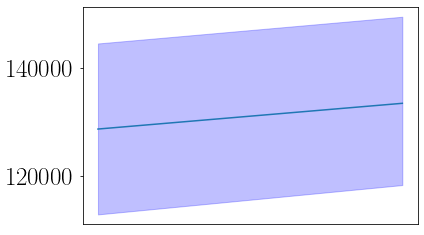

In [10]:
N=1
upper  = forecast['yhat_upper'].loc[0:N].to_numpy()
lower  = forecast['yhat_lower'].loc[0:N].to_numpy()
median = forecast['yhat'].loc[0:N].to_numpy()

plt.plot(forecast['ds'].loc[0:N], median)
plt.fill_between( forecast['ds'].loc[0:N], lower, upper , color = 'blue', alpha = 0.25)
plt.xticks([])


print('Upper ', upper)
print('Lower ', lower)
print('Median ', median)

print('Upper - median ', upper-median)
print('Median - lower', median-lower)
print('Upper - lower', upper-lower)
print('lower + (Upper - lower) / 2', 0.5*(upper-lower) + lower)

In [11]:
## Inspect the learned parameters of the model. In the point estimate we will have a single parameter
#  that parameterizes each of the g(t), s(t) and h(t). In the MCMC we will have as many as mcmc_samples we have
#  specified

# Remember we have: N(y | g(t) + s(t) + h(t), sigma_obs^2), where g(t) denotes the trend model, s(t) denotes seasonality and h(t) 
# denotes holidays. In this specific example we dont have h(t), we have just yearly seasonality with s(t). The number
# of fourier functions used by default for a year seasonality is N = 10 (see docs), so we have 2*N = 20 parameters 
# (one corresponding to sine and one to cosine). Another parameter is the sigma_obs^2 (the one giving credible intervals in the
# point estimate ), which models the noise in the output. On the other hand we have the trend model g(t). This trend
# model is a piecewise function where the pieces are specified by the change points. We can set where do we think
# the change points appear but if you dont, then by default prophet sets 25 locations and set an L1 prior over them
# so that change points can be driven to zero if they are not really needed to model the likelihood. By default
# prophet uses a linear trend model. This linear trend model has the parameter k (growth rate) and the parameter m
# (offset parameter). These parameters are the base growth and offset parameter, ie these parameters are adjusted
# at each change point location. Thus the dimension of these parameters is 1. Delta is the value used to adjust these
# parameters. Prophet has and additional model.params['trend'] which I am not sure exactly which parameter represents
# It has same dimensionality as training data.

print(model.params.keys())

print('Sigma observation model \n ', model.params['sigma_obs'])
## Note that sigma_obs is the noise in the observation model of a scaled version of the data, i.e prophet 
#  normalizes data and learns the model. Then predictions are performed by predicting with the normalized model
#  and then reescaling the output by the standard deviation. This is important in machine learning applications involving
#  regresion. For research there is no really matter where do you evaluate the model, but your prediction is only useful for
#  a client if it is given in the original scale.
print('Scale of the data ', model.y_scale)

print('Fourier coefficients    \n ', model.params['beta'].shape)

print('Places where prophet thinks a change point appears \n ', model.params['delta'].shape)
print(model.params['delta']) ## some of them are near to zero specifying no change point. This is what an L1 does.

print('Growth rate parameter \n',  model.params['k'].shape)

print('Offset parameter \n',  model.params['m'].shape)

print('No idea \n', model.params['trend'].shape)

dict_keys(['k', 'm', 'delta', 'sigma_obs', 'beta', 'trend'])
Sigma observation model 
  [[0.01528558]]
Scale of the data  518253.0
Fourier coefficients    
  (1, 20)
Places where prophet thinks a change point appears 
  (1, 25)
[[ 5.19289653e-08  3.15265717e-08  2.91254640e-08  1.40017231e-08
   7.16117984e-06  1.86994407e-05  8.46455390e-03  7.89951290e-09
  -2.18358344e-08 -1.72636278e-04 -1.79200739e-02 -2.30584940e-08
   1.58517072e-08  9.31197478e-02  1.68138513e-01  4.14672876e-08
   6.60553030e-08 -2.71468696e-06 -5.27610242e-01 -7.37196605e-01
  -8.58705483e-07  3.35778619e-01  9.27867195e-01 -4.44903794e-09
  -3.97061940e-02]]
Growth rate parameter 
 (1, 1)
Offset parameter 
 (1, 1)
No idea 
 (1, 293)


Text(0.5, 1.0, 'Full forecast')

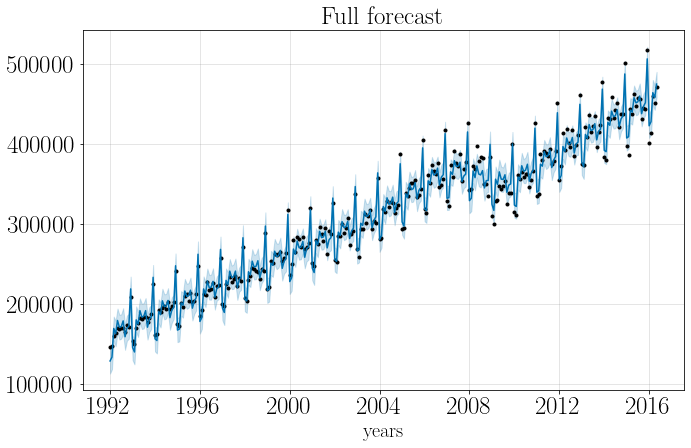

In [12]:
## Visualize forecasting
fig = model.plot(forecast)
plt.xlabel('years')
plt.ylabel('')
plt.title('Full forecast')

/home/jmaronasm/.conda/envs/PROPHET_TUTORIAL/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Text(0.5, 20.85921203689295, 'months')

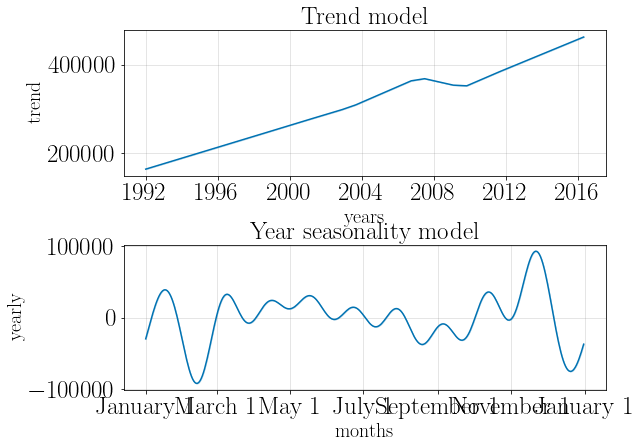

In [13]:
## Visualize the individual models used to create the observation model
fig     = model.plot_components(forecast)
ax1,ax2 = fig.get_axes()

ax1.set_xlabel('years')
ax1.set_title('Trend model')

ax2.set_title('Year seasonality model')
ax2.set_xlabel('months')



Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')


[]

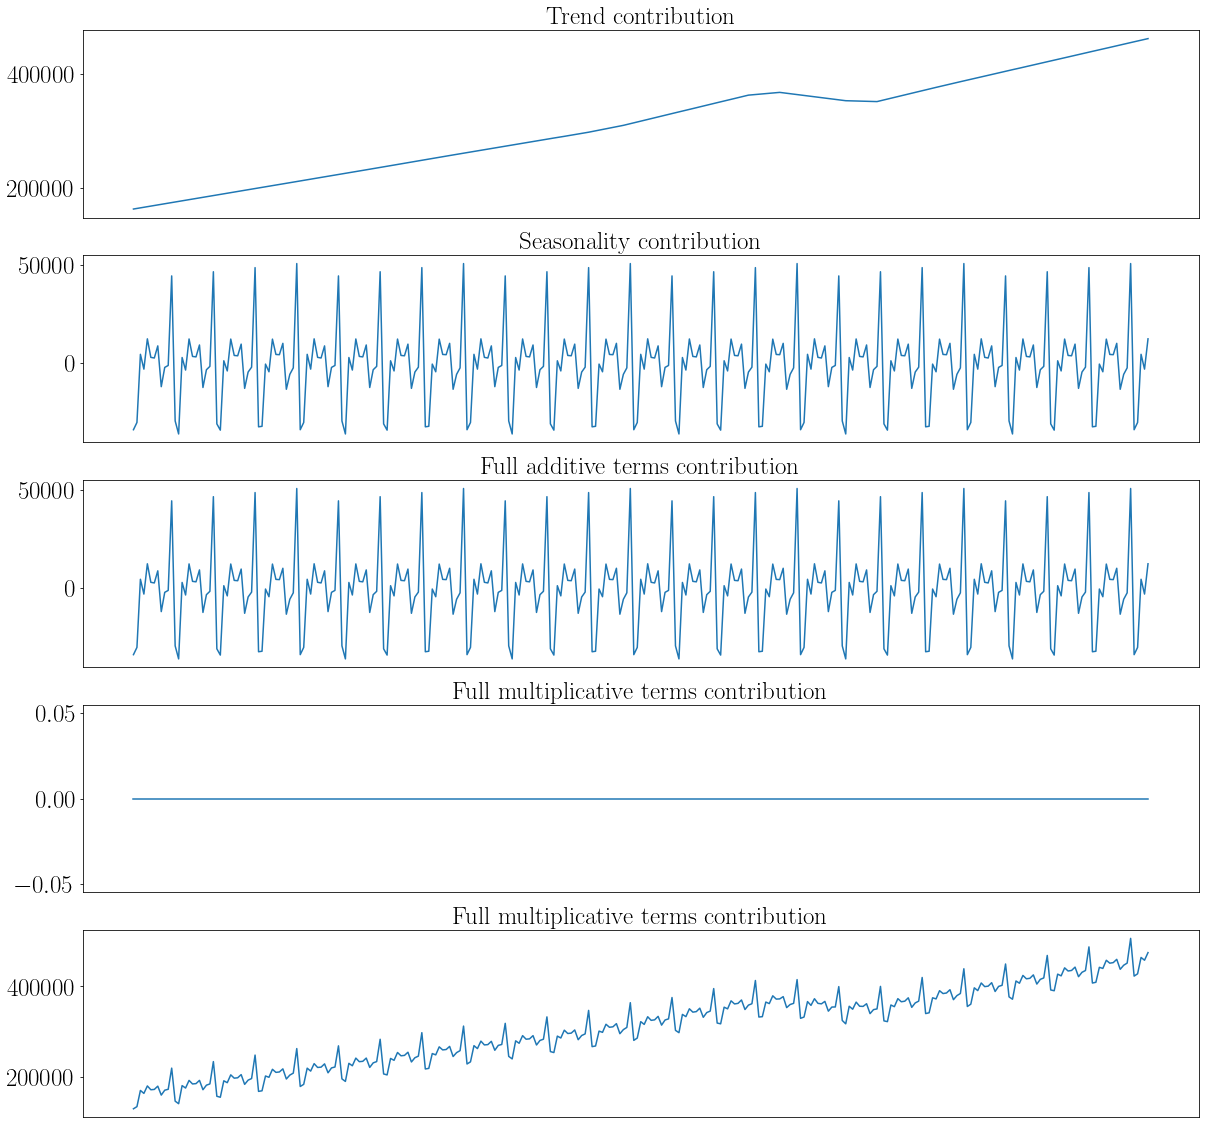

In [14]:
## Visualize the contribution of the individual models to the prediction. y(t) = g(t)+s(t) etc
print(forecast.keys())

x = np.arange(0,len(df['y']))
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,figsize=(20,20))

ax1.plot(forecast['trend'])
ax1.fill_between(np.arange(0,len(forecast['trend'])),forecast['trend_lower'],forecast['trend_upper'],alpha = 0.5)
ax1.set_title('Trend contribution')
ax1.set_xticks([])

ax2.plot(forecast['yearly'])
ax2.fill_between(np.arange(0,len(forecast['yearly'])),forecast['yearly_lower'],forecast['yearly_upper'],alpha = 0.5)
ax2.set_title('Seasonality contribution')
ax2.set_xticks([])

ax3.plot(forecast['additive_terms'])
ax3.fill_between(np.arange(0,len(forecast['additive_terms'])),forecast['additive_terms_lower'],forecast['additive_terms_upper'],alpha = 0.5)
ax3.set_title('Full additive terms contribution')
ax3.set_xticks([])

ax4.plot(forecast['multiplicative_terms'])
ax4.fill_between(np.arange(0,len(forecast['multiplicative_terms'])),forecast['multiplicative_terms_lower'],forecast['multiplicative_terms_upper'],alpha = 0.9)
ax4.set_title('Full multiplicative terms contribution')
ax4.set_xticks([])


ax5.plot(forecast['trend']+forecast['additive_terms'])
ax5.set_title('Full multiplicative terms contribution')
ax5.set_xticks([])



In [15]:
sim_values = model.predictive_samples(df)
print(sim_values.keys())
print(sim_values['yhat'].shape)

# compute quantiles
q_low, q_up = np.quantile(sim_values['yhat'], [0.025, 0.975], axis = 1) # lower and uper 95% credible

print(q_low)
print(q_up)

/home/jmaronasm/.conda/envs/PROPHET_TUTORIAL/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


dict_keys(['yhat', 'trend'])
(293, 2000)
[112470.35483475 117887.66205967 153429.25412796 146645.85875623
 163011.95013874 155363.87981897 155826.03369487 163827.41160669
 143846.3171658  154608.80564884 157021.86279589 204327.4369213
 130357.47942095 124763.08432366 164383.62401932 159172.35105566
 176474.25104903 169381.4616129  169216.53728202 176787.5750608
 155940.20834196 165871.42398443 168204.22794588 218456.67629337
 141650.81393558 138841.57390758 175616.56009425 170784.92602252
 189661.28710525 181728.56065744 182020.02069125 188554.84130879
 167084.8950714  176389.92016449 180654.25692637 232282.65458164
 151065.94393032 153390.58412522 185917.88717453 183347.04257686
 200752.71019588 194028.26695435 195062.91577638 202079.29053464
 179540.88114877 188207.52510911 192863.16409137 246608.39348411
 162875.90341245 167019.17441515 203655.74807274 196620.23867058
 213977.14680108 204762.95200235 205206.90789036 212099.6561839
 193503.83280498 203556.57857874 206243.15782865 252

In [16]:
## ========================================================================================== ##
## ====================================== Fit using MCMC   ================================== ##

## Create prophet model
model = Prophet( interval_width = 0.95, mcmc_samples = 300, uncertainty_samples = 20000 ) 

# with this we specify how many samples are drawn.
# uncertainty_samples is the number of samples used to estimate credible intervals. This is used by MCMC and point estimate
# since remember credible intervals are computed by sampling from p(y|x) (which can be a point estimate or a posterior
# predictive distribution)


In [17]:
## Now it samples from the posterior distribution. The output in stdout is that given by Stan.
#  Takes a bit longer since we have a warm up phase where the parameters of the No U Turn Sampler
#  (a variant of Hamiltonian Monte Carlo) are adjusted.
model.fit(df)

# It is important to note that Stan will give us output regarding the info of the MCMC diagnosis sampler, for example
# maximum tree depth saturation of divergences. This is something Stan specific (inherited from hierarchical models)
# and we might need some reparameterization to make the algorithm statistically efficient. We might not be able 
# to do this from prophet directly. We can, on the other hand, use MCMC diagnosis libraries such as arviz which will
# allow us to see if the MCMC algorithm has reached is stationary distribution and adjust and modify the parameters 
# of the sampling algorithm (number of warm up steps, number of chains run in parallel etc) to achieve optimality.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/jmaronasm/.conda/envs/PROPHET_TUTORIAL/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



Gradient evaluation took 0.000367 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.67 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000455 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.55 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000561 seconds
1000 transitions using 10 leapfrog steps per transition would take 5.61 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 300 [  0%]  (Warmup)

Gradient evaluation took 0.000485 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.85 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 300 [  0%]  (Warmup)
Iteration:   1 / 300 [  0%]  (Warmup)
Iteration:   1 / 300 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:



Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)




If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,If this warnin

Iteration:  30 / 300 [ 10%]  (Warmup)
Iteration:  30 / 300 [ 10%]  (Warmup)
Iteration:  30 / 300 [ 10%]  (Warmup)
Iteration:  30 / 300 [ 10%]  (Warmup)
Iteration:  60 / 300 [ 20%]  (Warmup)
Iteration:  60 / 300 [ 20%]  (Warmup)
Iteration:  60 / 300 [ 20%]  (Warmup)
Iteration:  90 / 300 [ 30%]  (Warmup)
Iteration:  60 / 300 [ 20%]  (Warmup)
Iteration:  90 / 300 [ 30%]  (Warmup)
Iteration:  90 / 300 [ 30%]  (Warmup)
Iteration: 120 / 300 [ 40%]  (Warmup)
Iteration: 120 / 300 [ 40%]  (Warmup)
Iteration:  90 / 300 [ 30%]  (Warmup)
Iteration: 120 / 300 [ 40%]  (Warmup)
Iteration: 150 / 300 [ 50%]  (Warmup)
Iteration: 151 / 300 [ 50%]  (Sampling)
Iteration: 150 / 300 [ 50%]  (Warmup)
Iteration: 151 / 300 [ 50%]  (Sampling)
Iteration: 150 / 300 [ 50%]  (Warmup)
Iteration: 151 / 300 [ 50%]  (Sampling)
Iteration: 180 / 300 [ 60%]  (Sampling)
Iteration: 120 / 300 [ 40%]  (Warmup)
Iteration: 180 / 300 [ 60%]  (Sampling)
Iteration: 180 / 300 [ 60%]  (Sampling)
Iteration: 210 / 300 [ 70%]  (Sampling

In [18]:
## Make a prediction. In this case we predict in the same time slot we have train on
forecast = model.predict(df)

'''
   We see info is the same provided by point estimate model, with some differences we will analyze now. The first
   of course is that know we should expect credible intervals to vary accross time.
'''

print(forecast.keys())

/home/jmaronasm/.conda/envs/PROPHET_TUTORIAL/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jmaronasm/.conda/envs/PROPHET_TUTORIAL/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')


In [19]:
## Check the output of credible intervals. We can see how in the point estimate they don't match.

yhat_lower = forecast['yhat_lower']
yhat_upper = forecast['yhat_upper']
yhat       = forecast['yhat']


print('Difference between upper interval and median \n', yhat_upper[0:3]-yhat[0:3])
print('Difference between median and lower interval \n',yhat[0:3]-yhat_lower[0:3])

Difference between upper interval and median 
 0    16911.442455
1    16917.381820
2    17193.754307
dtype: float64
Difference between median and lower interval 
 0    16832.597924
1    16949.351436
2    17017.392785
dtype: float64


Upper  [146542.67774714 150998.44065328]
Lower  [112798.63736751 117131.70739755]
Median  [129631.23529181 134081.05883307]
Upper - median  [16911.44245533 16917.38182021]
Median - lower [16832.5979243  16949.35143553]
Upper - lower [33744.04037963 33866.73325574]
lower + (Upper - lower) / 2 [129670.65755733 134065.07402542]


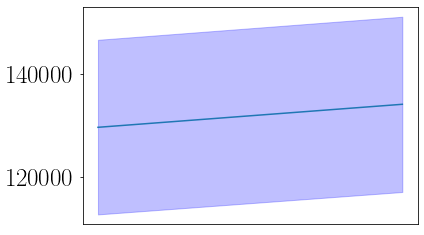

In [20]:
N=1
upper  = forecast['yhat_upper'].loc[0:N].to_numpy()
lower  = forecast['yhat_lower'].loc[0:N].to_numpy()
median = forecast['yhat'].loc[0:N].to_numpy()

plt.plot(forecast['ds'].loc[0:N], median)
plt.fill_between( forecast['ds'].loc[0:N], lower, upper , color = 'blue', alpha = 0.25)
plt.xticks([])


print('Upper ', upper)
print('Lower ', lower)
print('Median ', median)

print('Upper - median ', upper-median)
print('Median - lower', median-lower)
print('Upper - lower', upper-lower)
print('lower + (Upper - lower) / 2', 0.5*(upper-lower) + lower)

In [21]:
## Inspect the learned parameters of the model. In the point estimate we will have a single parameter
#  that parameterizes each of the g(t), s(t) and h(t). In the MCMC we will have as many as mcmc_samples we have
#  specified

# Same parameters as in the point estimate except that know rather than having a single point estimate parameter
# we have as many parameters as samples from the posterior distribution (removing the warm up phase of the algorithm).
# Since we choose 300 parameters, the warm up phase takes 150 samples and stan runs 4 chains in parallel, we have 
# 600 hundreds parameters. Note that beyond this 600 the dimensionality of parameters is the same as in the point estimate

print(model.params.keys())

print('Sigma observation model \n ', model.params['sigma_obs'].shape)

print('Fourier coefficients    \n ', model.params['beta'].shape)

print('Places where prophet thinks a change point appears \n ', model.params['delta'].shape)

print('Growth rate parameter \n',  model.params['k'].shape)

print('Offset parameter \n',  model.params['m'].shape)

print('No idea \n', model.params['trend'].shape)

dict_keys(['k', 'm', 'delta', 'sigma_obs', 'beta', 'trend'])
Sigma observation model 
  (600,)
Fourier coefficients    
  (600, 20)
Places where prophet thinks a change point appears 
  (600, 25)
Growth rate parameter 
 (600,)
Offset parameter 
 (600,)
No idea 
 (600, 293)


Text(0.5, 1.0, 'Full forecast')

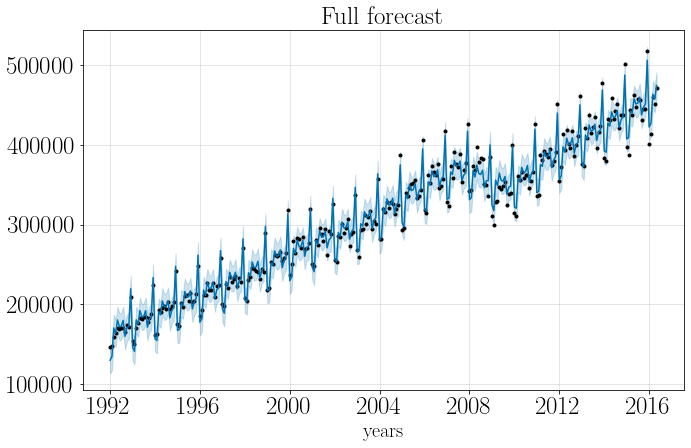

In [22]:
## Visualize forecasting
fig = model.plot(forecast)
plt.xlabel('years')
plt.ylabel('')
plt.title('Full forecast')

/home/jmaronasm/.conda/envs/PROPHET_TUTORIAL/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Text(0.5, 20.85921203689295, 'months')

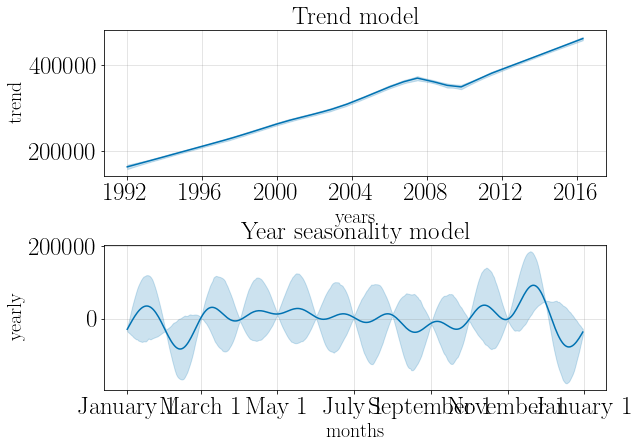

In [23]:
## Visualize the individual models used to create the observation model. Note that now since we use MCMC
#  we model uncertainty in the component models. In other words rather than using a single model for the
#  seasonality, we have a seasonality model that provides the probability of the seasonality effect being in some interval
#  With few data this gives a lot of robustness because you can tell your client, my prediction is X, with 95% probability
#  lying in some interval. The tightes this interval, the more sure you can tell the client you are about prediction X.
#  If the interval is very width, then you can tell your client I am not sure. This behaviour is only achieved by MCMC
#  since remember in the point estimate the credible interval comes from a fixed noise parameter.
fig     = model.plot_components(forecast)
ax1,ax2 = fig.get_axes()

ax1.set_xlabel('years')
ax1.set_title('Trend model')

ax2.set_title('Year seasonality model')
ax2.set_xlabel('months')


Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')


[]

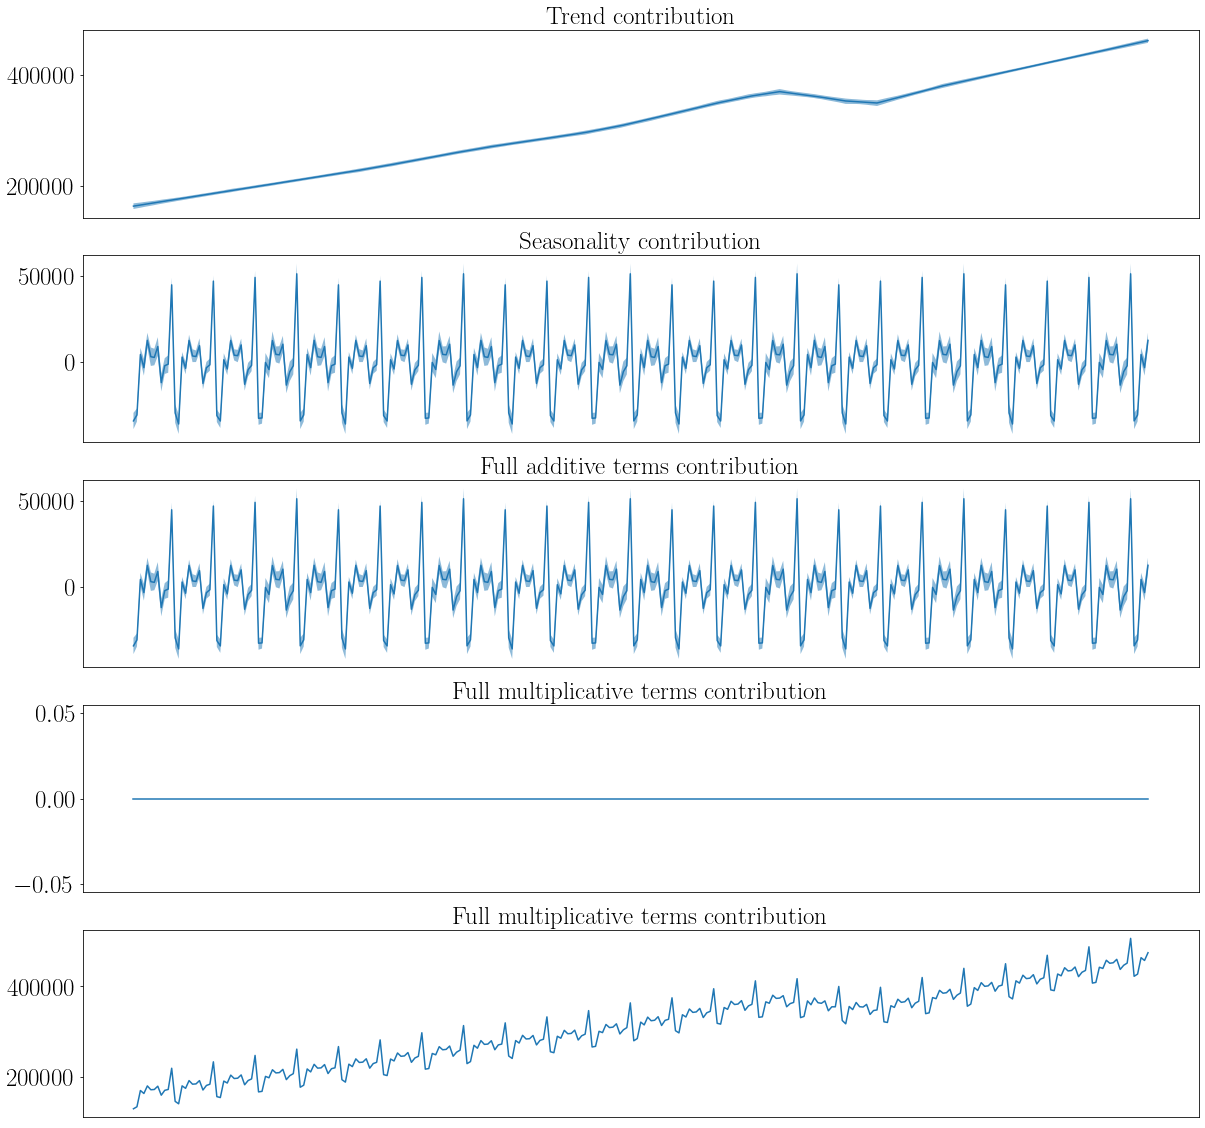

In [24]:
## Visualize the contribution of the individual models to the prediction. y(t) = g(t)+s(t) etc
print(forecast.keys())

x = np.arange(0,len(df['y']))
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,figsize=(20,20))

ax1.plot(forecast['trend'])
ax1.fill_between(np.arange(0,len(forecast['trend'])),forecast['trend_lower'],forecast['trend_upper'],alpha = 0.5)
ax1.set_title('Trend contribution')
ax1.set_xticks([])

ax2.plot(forecast['yearly'])
ax2.fill_between(np.arange(0,len(forecast['yearly'])),forecast['yearly_lower'],forecast['yearly_upper'],alpha = 0.5)
ax2.set_title('Seasonality contribution')
ax2.set_xticks([])

ax3.plot(forecast['additive_terms'])
ax3.fill_between(np.arange(0,len(forecast['additive_terms'])),forecast['additive_terms_lower'],forecast['additive_terms_upper'],alpha = 0.5)
ax3.set_title('Full additive terms contribution')
ax3.set_xticks([])

ax4.plot(forecast['multiplicative_terms'])
ax3.fill_between(np.arange(0,len(forecast['multiplicative_terms'])),forecast['multiplicative_terms_lower'],forecast['multiplicative_terms_upper'],alpha = 0.5)
ax4.set_title('Full multiplicative terms contribution')
ax4.set_xticks([])


ax5.plot(forecast['trend']+forecast['additive_terms'])
ax5.set_title('Full multiplicative terms contribution')
ax5.set_xticks([])


In [25]:
sim_values = model.predictive_samples(df)
print(sim_values.keys())
print(sim_values['yhat'].shape)

# compute quantiles
q_low, q_up = np.quantile(sim_values['yhat'], [0.05, 0.95], axis = 1) # lower and uper 95% credible

print(q_low)
print(q_up)

/home/jmaronasm/.conda/envs/PROPHET_TUTORIAL/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


dict_keys(['yhat', 'trend'])
(293, 20400)
[115340.65736324 119885.73403293 155808.88102346 149149.97305496
 165900.39526311 157266.02939191 158141.23178504 165305.80076784
 145565.5612623  156278.87134958 158242.77849419 205250.83272051
 131802.06192991 126577.82531744 166543.70539383 161127.5967527
 178361.71523314 170175.76471062 171022.19237775 178354.70645138
 157618.05389356 167340.58269103 170392.90273306 219842.9526307
 142752.94587701 140789.29042886 177224.42695737 172793.1444955
 190524.71490011 183073.9498665  183666.94328725 190847.27864923
 169273.02034404 178399.95403361 181830.57934236 233929.01391817
 153451.5378897  154605.75204348 187151.21315188 184133.08609079
 201931.24086131 194923.45909008 195781.22005406 202964.02908318
 180268.32839331 188725.35059127 193429.44077748 247706.17665707
 163700.95016037 167727.63656115 203502.2556627  197324.04965362
 214148.60607694 205433.38184159 206259.79301183 213418.47119411
 193522.03948042 204501.46865119 206290.87672905 25